# Background
- **Author**: `<林宜萱>`
- **Created At**: `<2025-10-26>`
- **Path to Training Data：extent-of-discount-rate-DE_train.csv**
- **Path to Testing Data：extent-of-discount-rate-DE_test.csv**
- **Model Specification 
    - Method：Random Forest Regression
    - Variables：
    Dependent Variable (y): DiscountRate  
    Independent Variables (X):  
    ["Age", "AccumulatedPositiveRate", "SalePeriod",
 "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M",
 "FollowersGrowthRate1W", "FollowersGrowthRate2W", "FollowersGrowthRate1M",
 "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M",
 "DLC_since_last_discount", "Sequel_since_last_discount"]
    - Tuning Parameters：
      - `test_size = 0.2`    
      - `random_state = 42`   
      - `n_estimators = 200`   
      - `n_jobs = -1`   

    - Optimization Method：
    The model is trained via ensemble learning using Random Forests, which aggregates multiple decision trees trained on bootstrapped subsets of data to minimize prediction variance and capture non-linear relationships among variables.
- **Main Findings and Takeaways：**
    - In-sample `< R², RMSE>`:  
    1w(0.9640, 0.0361)、2w(0.9671, 0.0345)、1m(0.9668, 0.0346)
    - Out-sample `< R², RMSE>`:  
    1w(0.7199, 0.0814)、2w(0.6291, 0.0937)、1m(0.6683, 0.0886)  
    - Feature Importance Ranking:  
  | 1 | AccumulatedPositiveRate |   
  | 2 | Age |   
  | 3 | FollowersGrowthRate |   
  | 4 | PositiveRateGrowthRate |   
  | 5 | PlayerGrowthRate |   
  | 6 | SalePeriod |   
  | 7 | DLC_since_last_discount |   
  | 8 | Sequel_since_last_discount |   

    - Interpretation:  
- 模型在訓練資料上表現優異（R² 約 0.96），同時在測試資料上仍維持良好的解釋力（R² 約 0.72），顯示 Random Forest 能有效捕捉主要特徵模式，且未出現明顯的過度擬合。    
- 在所有變數中，**AccumulatedPositiveRate**、**Age** 以及 **FollowersGrowthRate** 對折扣率的影響最大。   
- **long-term user sentiment** (positive review accumulation) and **community engagement** (follower and player growth) 是影響折扣策略幅度的主要因素。    
- 相較之下，與**recent discount history** (DLC and sequel timing)相關的變數影響力較小，定價決策更可能受到遊戲表現與聲譽的影響，而非過往促銷紀錄。
- **Future Direciton：採用 交叉驗證 與 超參數調整（如 Grid Search、Random Search）來優化模型的穩健性與泛化能力。**

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv('../data/processed/extent-of-discount-rate-DE.csv')

In [4]:
df.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,...,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.033624,-0.037584,0.000673,0.001362,0.003116,0.000053,0.000015,0.000023,0,0
1,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.022963,0.003837,0.000553,0.001087,0.002301,0.000004,0.000031,-0.000026,0,0
2,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,-0.039165,0.015256,0.001381,0.002082,0.004059,-0.000146,-0.000165,-0.000152,0,0
3,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,...,-0.033895,-0.006214,0.000790,0.001743,0.004781,0.000016,0.000014,-0.000011,0,0
4,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.044649,0.012697,0.000952,0.001814,0.003629,0.000002,-0.000022,-0.000005,0,0


In [5]:
# 定義特徵與目標 
base_features = [
    "Age", "AccumulatedPositiveRate", "SalePeriod", "DiscountFreq3M",
    "DLC_since_last_discount", "Sequel_since_last_discount"
]

feature_sets = {
    "1W": ["PlayerGrowthRate1W", "FollowersGrowthRate1W", "PositiveRateGrowthRate1W"],
    "2W": ["PlayerGrowthRate2W", "FollowersGrowthRate2W", "PositiveRateGrowthRate2W"],
    "1M": ["PlayerGrowthRate1M", "FollowersGrowthRate1M", "PositiveRateGrowthRate1M"]
}

y = df["DiscountRate"]


🔹 Training Model: 1W


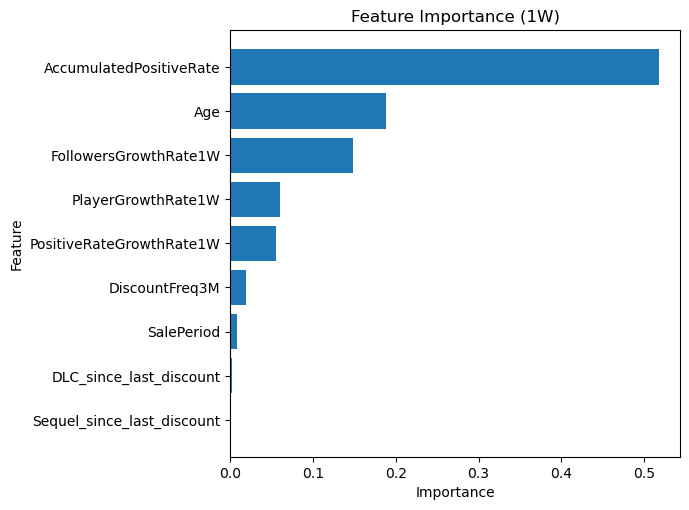


🔹 Training Model: 2W


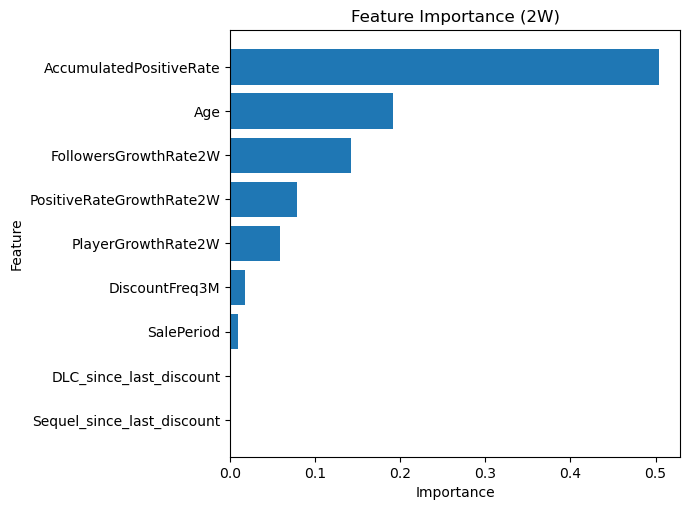


🔹 Training Model: 1M


c:\Users\user\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


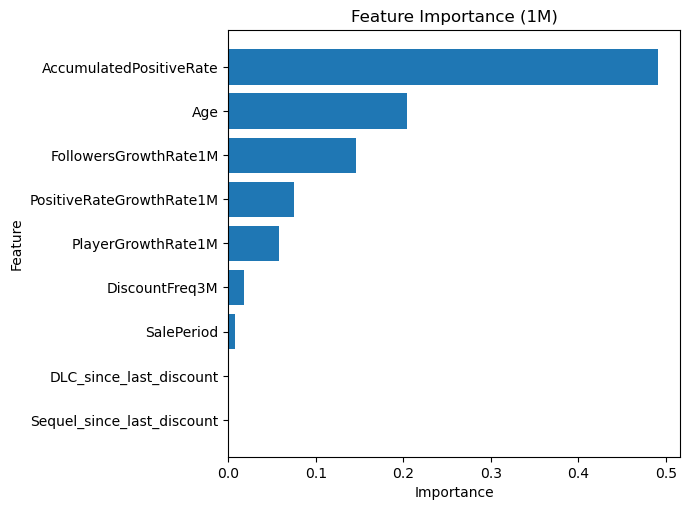


=== Model Performance Summary ===
Model                                                                                                                      Best Params  Train R²  Test R²  Train RMSE  Test RMSE
   1W {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}    0.9909   0.7291      0.0187     0.0952
   2W {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}    0.9729   0.7414      0.0323     0.0931
   1M   {'bootstrap': False, 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}    0.9699   0.7535      0.0340     0.0909


In [6]:
def plot_rf_importance(model, feature_names, top_n=20):
    """Plot feature importance for RandomForest / Tree-based models."""
    if hasattr(model, "feature_importances_"):
        importance = pd.DataFrame({
            "feature": feature_names,
            "importance": model.feature_importances_
        })
    else:
        raise ValueError("Model has no feature_importances_ attribute.")

    importance = importance.sort_values(by="importance", ascending=False).head(top_n)

    plt.barh(importance["feature"], importance["importance"])
    plt.gca().invert_yaxis()  # 重要性大的排上面
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()


# =============================
# Random Forest Grid Search 設定
# =============================
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

results = []

# ======================================
# 針對每個模型組合（feature_sets）做訓練
# ======================================
for label, growth_features in feature_sets.items():
    print(f"\n🔹 Training Model: {label}")

    # 合併特徵
    X = df[base_features + growth_features]
    
    # 切分資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 建立模型
    model = RandomForestRegressor()

    # Grid Search 尋找最佳參數
    grid = GridSearchCV(model, param_grid, scoring='r2', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # 預測
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # 評估
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    # 儲存結果
    results.append({
        "Model": label,
        "Best Params": grid.best_params_,
        "Train R²": round(train_r2, 4),
        "Test R²": round(test_r2, 4),
        "Train RMSE": round(train_rmse, 4),
        "Test RMSE": round(test_rmse, 4)
    })

    # 畫出特徵重要性
    plt.figure(figsize=(7, 5))
    plot_rf_importance(best_model, X_train.columns, top_n=15)
    plt.title(f"Feature Importance ({label})")
    plt.show()

# =============================
# 統整結果輸出
# =============================
result_df = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
print(result_df.to_string(index=False))

#### 檢查共線性

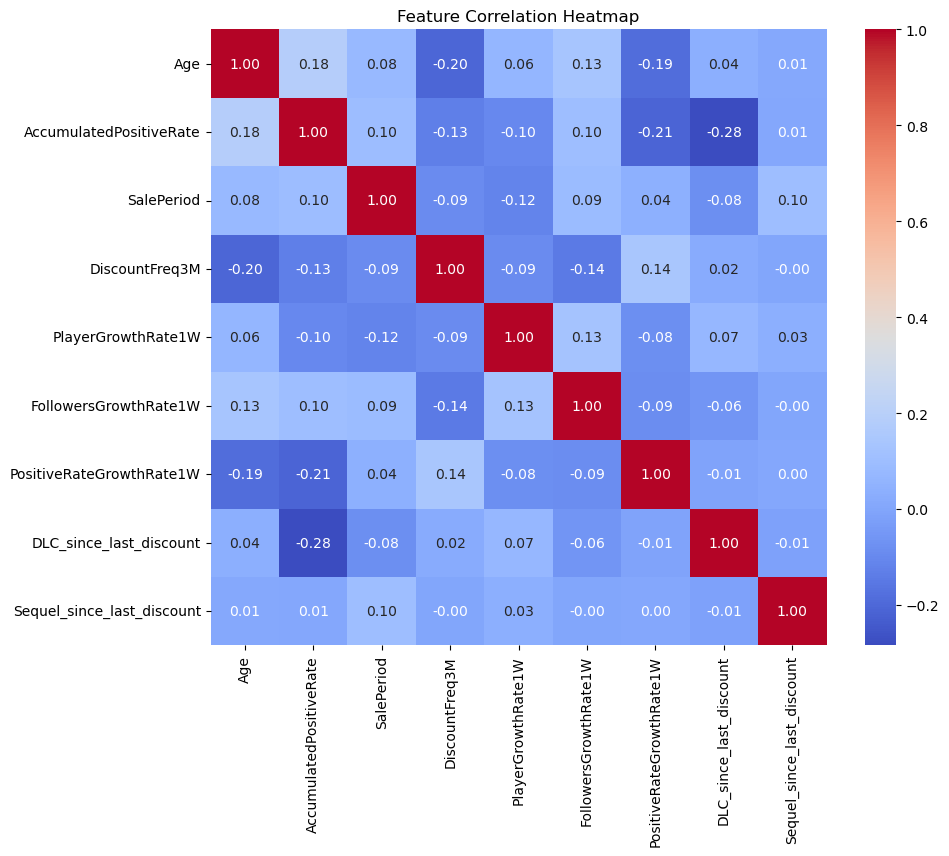

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 只選數值型特徵（排除目標變數與時間）
features = ["Age", "AccumulatedPositiveRate", "SalePeriod",
            "DiscountFreq3M", "PlayerGrowthRate1W", "FollowersGrowthRate1W",
            "PositiveRateGrowthRate1W", "DLC_since_last_discount",
            "Sequel_since_last_discount"]

corr = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 特徵欄位
features = ["Age", "AccumulatedPositiveRate", "SalePeriod", "DiscountFreq3M",
            "PlayerGrowthRate1W", "FollowersGrowthRate1W", "PositiveRateGrowthRate1W",
            "DLC_since_last_discount", "Sequel_since_last_discount"]

X = df[features]

# 計算 VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                      Feature        VIF
0                         Age   4.584643
1     AccumulatedPositiveRate  17.090120
2                  SalePeriod   1.814630
3              DiscountFreq3M  10.012752
4          PlayerGrowthRate1W   1.130120
5       FollowersGrowthRate1W   2.014749
6    PositiveRateGrowthRate1W   1.142578
7     DLC_since_last_discount   1.045911
8  Sequel_since_last_discount   1.020486
